In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataset import KSponSpeechDataset, DataCollate
from torch.utils.data import DataLoader
from jamo import n_symbols, text_to_tokens, tokens_to_text

### Dataset

In [4]:
dataset = KSponSpeechDataset(root_dir='/data/KsponSpeech')
train_loader = DataLoader(dataset, num_workers=8, shuffle=True, batch_size=16, collate_fn=DataCollate())
print(train_loader)

622545


### Model

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, num_layers):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv1d(input_channels, hidden_channels, kernel_size=3, padding=1),
                                  nn.BatchNorm1d(hidden_channels),
                                  nn.ReLU(),
                                  nn.Conv1d(hidden_channels, hidden_channels, kernel_size=1))
        self.lstm = nn.LSTM(input_size=hidden_channels, hidden_size=hidden_channels//2, num_layers=num_layers, 
                            batch_first=True, dropout=0.1, bidirectional=True)
        self.out_layer = nn.Linear(hidden_channels, output_channels)
        
    def forward(self, inputs, input_lengths):
        # inputs : (B, T, C)
        # input_lengths : (B)
        
        # (B, T, C)
        x = self.conv(inputs.transpose(1, 2)).transpose(1, 2)
        x = nn.utils.rnn.pack_padded_sequence(x, input_lengths.cpu(), batch_first=True, enforce_sorted=False)
        x, _ = self.lstm(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        x = self.out_layer(x)
        
        return x
        

In [6]:
class Decoder(nn.Module):
    def __init__(self, n_labels, embedding_size, hidden_channels, output_channels, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(n_labels, embedding_size)
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=hidden_channels, num_layers=num_layers,
                            batch_first=True, dropout=0.1, bidirectional=False)
        self.out_layer = nn.Linear(hidden_channels, output_channels)
        
    def forward(self, targets, target_lengths):
        # targets : (B, U)
        # target_lengths : (B)
        
        # (B, U, C)
        x = self.embedding(targets)
        x = nn.utils.rnn.pack_padded_sequence(x, target_lengths.cpu(), batch_first=True, enforce_sorted=False)
        x, _ = self.lstm(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        x = self.out_layer(x)
        
        return x
    
    def inference(self, target, state):
        # target : (B, 1)
        
        # (B, 1, C)
        x = self.embedding(target)
        x, state = self.lstm(x, state)
        x = self.out_layer(x)
        
        # (B, C), state
        return x[:, 0], state

In [7]:
class JointNetwork(nn.Module):
    def __init__(self, output_channels, hidden_channels, n_labels):
        super().__init__()
        
        self.out_layer = nn.Sequential(nn.Linear(output_channels*2, hidden_channels),
                                   nn.Tanh(),
                                   nn.Linear(hidden_channels, n_labels))
        
    def forward(self, encoded, decoded):
        # encoded : (B, T, C)
        # decoded : (B, U, C)
        
        t = encoded.size(1)
        u = decoded.size(1)
        
        # (B, T, 1, C)
        encoded = encoded.unsqueeze(dim=2)
        # (B, T, U, C)
        encoded = encoded.repeat([1, 1, u, 1])
        
        # (B, 1, U, C)
        decoded = decoded.unsqueeze(dim=1)
        # (B, T, U, C)
        decoded = decoded.repeat([1, t, 1, 1])
        
        # (B, T, U, C)
        y = torch.cat([encoded, decoded], dim=3)
        # (B, T, U, C)
        y = self.out_layer(y)
        
        return y
    
    def inference(self, encoded, decoded):
        # encoded : (1, C)
        # decoded : (1, C)
        
        # (1, C)
        y = torch.cat([encoded, decoded], dim=1)
        # (1, C)
        y = self.out_layer(y)
        
        return y
    

In [75]:
import warp_rnnt
import matplotlib.pyplot as plt

class Model(nn.Module):
    def __init__(self, input_channels,
                       n_labels,
                       embedding_size,
                       encoder_hidden_channels,
                       decoder_hidden_channels,
                       joint_hidden_channels,
                       output_channels, 
                       encoder_num_layers,
                       decoder_num_layers): 
        super().__init__()
        self.encoder = Encoder(input_channels, encoder_hidden_channels, output_channels, encoder_num_layers)
        self.decoder = Decoder(n_labels, embedding_size, decoder_hidden_channels, output_channels, decoder_num_layers)
        self.joint = JointNetwork(output_channels, joint_hidden_channels, n_labels)

    def forward(self, inputs, input_lengths, targets, target_lengths):
        # inputs : (B, T, C)
        # input_lengths : (B)
        # targets : (B, L)
        # target_lengths : (B)
        
        # (B, T, C)
        encoded = self.encoder(inputs, input_lengths)
        # (B, 1+U, C)
        decoded = self.decoder(F.pad(targets, (1, 0)), target_lengths+1)
        # (B, T, 1+U, n_labels)
        outputs = self.joint(encoded, decoded)
        # (B, T, 1+U, n_labels)
        log_probs = outputs.log_softmax(dim=3)
        # (,)
        loss = warp_rnnt.rnnt_loss(log_probs, targets.int(), input_lengths.int(), target_lengths.int(), average_frames=True, reduction='mean', gather=True)
        
        outputs = {'loss': loss,
                   'log_probs': log_probs}
        
        return outputs
    
    def inference(self, inputs, input_lengths):
        # inputs : (1, T, C)
        # input_lengths : (1)
        
        # (1, T, C)
        encoded = self.encoder(inputs, input_lengths)
        decoded = None
        decoder_state = None
        # (1, 1)
        label = torch.IntTensor([[0]]).cuda()
        label_list = [label]
        
        for t in range(0, input_lengths[0].item()):
            for _ in range(5): # 한 time step에서 출력할 수 있는 최대 label갯수 지정
                if decoded is None:
                    decoded, new_decoder_state = self.decoder.inference(label_list[-1], decoder_state)
                # (1, C)
                output = self.joint.inference(encoded[:, t], decoded)
                # (1, C)
                probability = torch.softmax(output, dim=1)
                # (1, 1)
                label = torch.argmax(probability, dim=1, keepdim=True)
                if label[0, 0] != 0:
                    label_list.append(label)
                    decoder_state = new_decoder_state
                    decoded = None
                else:
                    break
        
        # (1, T)
        labels = torch.cat(label_list, dim=1)
        
        return labels
    
    def beam_search(self, inputs, input_lengths, W=10):
        # (1, T, C)
        encoded = self.encoder(inputs, input_lengths)
        B = [{'score': 0.0, 'labels': [0], 'state': None}]
        
        for t in range(input_lengths[0].item()):
            A = B
            B = []
            
            # While B contains less than W (beam width) elements
            # more probablie than the most probable in A
            while True:
                A_max = max(A, key=lambda x:x['score'])
                A.remove(A_max)
                
                token = torch.IntTensor([[A_max['labels'][-1]]]).cuda()
                decoded, new_state = self.decoder.inference(token, A_max['state'])
                # (1, C)
                output = self.joint.inference(encoded[:, t], decoded)
                # (1, C)
                log_prob = torch.log_softmax(output, dim=1)
                
                for k in range(log_prob.shape[1]):
                    if k == 0:
                        hypothesis = {'score': A_max['score'] + log_prob[0, 0].item(),
                                      'labels': A_max['labels'][:],
                                      'state': A_max['state']}
                        B.append(hypothesis)
                    else:
                        hypothesis = {'score': A_max['score'] + log_prob[0, k].item(),
                                      'labels': A_max['labels'][:] + [k],
                                      'state': new_state}
                        A.append(hypothesis)
                
                # While loop exist condition
                A_max = max(A, key=lambda x:x['score'])
                B_candidate = [h for h in B if h['score'] > A_max['score']]
                if len(B_candidate) >= W:
                    B = B_candidate
                    break
        
        B = sorted(B, key=lambda x: x['score'], reverse=True)[:W]
        
        return B
                

### Logger

In [76]:
from utils import sizeof_fmt, Logger

In [77]:
!mkdir save
save_dir = 'save/transducer_lstm_kspon'
logger = Logger(save_dir=save_dir, new=False)
print(logger)

mkdir: cannot create directory ‘save’: File exists


In [78]:
!ls $save_dir

data.json   save_15000	save_25000  save_40000	save_41172  save_5000
save_0	    save_20000	save_30000  save_40191	save_43400
save_10000  save_23352	save_35000  save_40790	save_45000


### Init Model

In [79]:
model = Model(input_channels=80,
               n_labels=n_symbols,
               embedding_size=256,
               encoder_hidden_channels=512,
               decoder_hidden_channels=512,
               joint_hidden_channels=512,
               output_channels=256, 
               encoder_num_layers=3,
               decoder_num_layers=2)
model = model.cuda()
step = 43400

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

if True:
    model, optimizer, step = logger.load(step, model, optimizer)
    print('loaded', step)

Model size 36.5MiB
loaded : 43400
loaded 43400


In [80]:
def to_cuda(batch):
    batch['audio'] = batch['audio'].cuda()
    batch['audio_lengths'] = batch['audio_lengths'].cuda()
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    
    return batch

### Train

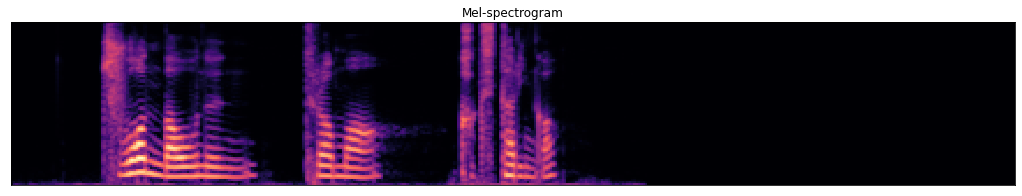

Ground Truth
주원 나오는 드라마 각시탈인가?
Greedy Search
 주원 나오는 드라마 각시 탈인가
Beam Search
 주원 나오는 드라마 각시 탈인가 score : -25.653615780852306
 주원 나오는 드라마 각시 탈인가 score : -25.990869781214315
 주원 나오는 드라마 각시 탈인가 score : -26.10609991147885


In [85]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

stop = True
while True: 
    for batch in train_loader:
        model.train()
        batch = to_cuda(batch)
        
        model.zero_grad()
        outputs = model(batch['audio'], batch['audio_lengths'], batch['text'], batch['text_lengths'])
        outputs['loss'].backward()
        optimizer.step()
        
        if step % 10 == 0:
            print(step, outputs['loss'].item())
            
        if step % 100 == 0:
            display.clear_output()
            
            plt.figure(figsize=[18, 3])
            plt.title('Mel-spectrogram')
            librosa.display.specshow(batch['audio'][0].data.cpu().numpy().T)
            plt.show()
            
            print('Ground Truth')
            print(tokens_to_text(batch['text'][0, :batch['text_lengths'][0]].cpu().numpy()))

            model.eval()
            with torch.no_grad():
                tokens = model.inference(batch['audio'][0:1], batch['audio_lengths'][0:1])
                _tokens = tokens[0].data.cpu().numpy()
                print('Greedy Search')
                print(tokens_to_text(_tokens))
                
                hypothesis_list = model.beam_search(batch['audio'][0:1], batch['audio_lengths'][0:1], W=3)
                print('Beam Search')
                for h in hypothesis_list:
                    print(tokens_to_text(h['labels']), 'score :', h['score'])
                    
            logger.log(step, 'loss', outputs['loss'].item())
            if stop:
                break
                    
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
    
        step += 1
        
    if stop:
        break


In [ ]:
logger.save(step, model, optimizer)